<a href="https://colab.research.google.com/github/ojhaajy/Tesla_Stock_Prediction/blob/main/DOUBT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tesla_stocks = pd.read_csv('tesla_stocks.csv')

In [3]:
tesla_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
data_to_use = tesla_stocks['Close'].values

In [5]:
scaler = StandardScaler()

In [6]:
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))

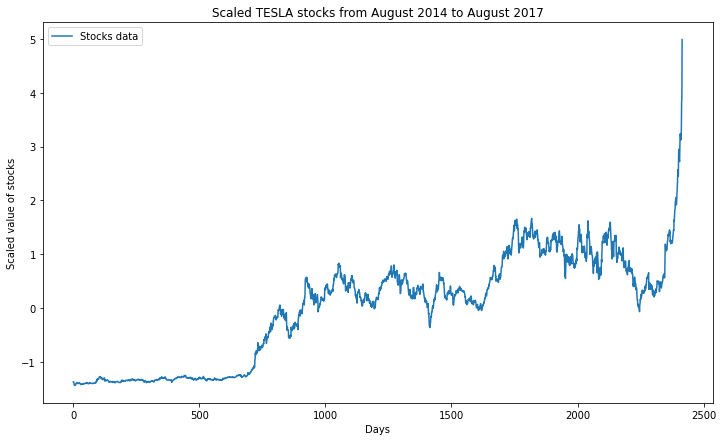

In [7]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from August 2014 to August 2017')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(scaled_data, label='Stocks data')
plt.legend()
plt.show()

In [8]:
def window_data(data, window_size):
    '''
    This function is used to create Features and Labels datasets. By windowing the data.
    
    Input: data - dataset used in the project
           window_size - how many data points we are going to use to predict the next datapoint in the sequence 
                       [Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
    
    Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
             y - 'labels', actually this is the next number in the sequence, this number we are trying to predict
    '''
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [9]:
X, y = window_data(scaled_data, 7)

In [10]:
X_train  = np.array(X[:700])
y_train = np.array(y[:700])

X_test = np.array(X[700:])
y_test = np.array(y[700:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 7, 1)
y_train size: (700, 1)
X_test size: (1709, 7, 1)
y_test size: (1709, 1)


In [11]:
#Hyperparameters used in the network
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 200 

In [18]:
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

In [19]:
# LSTM weights
#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

In [20]:
## Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

In [21]:
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output

In [22]:
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)

In [23]:
outputs

[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_383:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_447:0' shape=(1, 1) dtype=float32>]

In [24]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

In [25]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

In [26]:
session = tf.Session()

In [27]:
session.run(tf.global_variables_initializer())

In [28]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.1259486824274063
Epoch 30/200  Current loss: 0.0035471206065267324
Epoch 60/200  Current loss: 0.0027062634471803904
Epoch 90/200  Current loss: 0.0023909364826977253
Epoch 120/200  Current loss: 0.0023118744138628244
Epoch 150/200  Current loss: 0.002311684424057603
Epoch 180/200  Current loss: 0.0023120101541280746


In [29]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [30]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([outputs], feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [31]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [32]:
test_results = []
for i in range(749):
    if i >= 701:
        test_results.append(tests_new[i-701])
    else:
        test_results.append(None)

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


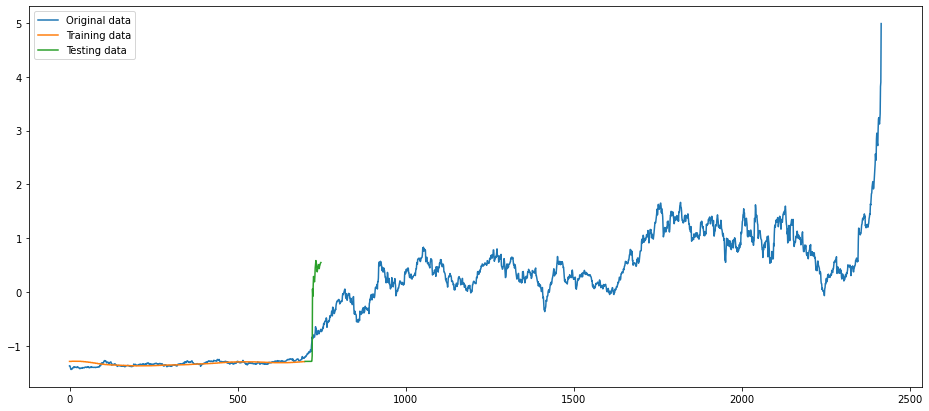

In [33]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()